# To start, we need to import our packages and also the file with the desired sample of movies

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import regex as re

In [4]:
flat_list_df = pd.read_csv ('lista_imdb_links_2020_2021.csv')
flat_list = flat_list_df['imdb_link'].tolist()

In [ ]:
# This loop will webscrap de IMDB page with the list of all films from this timeframe, taking the link for each movie

url = 'https://www.imdb.com/search/title/?title_type=feature,tv_movie&release_date=2020-01-01,2021-12-31'
url_list = []

try:
    for i in range (0,541):
        if i <= 539:
            response = requests.get(url)
            soup = BeautifulSoup(response.content, features = 'lxml')

            list_detail = soup.find_all('div', attrs = {'class':'lister-item-content'})
            url_list_now = ["https://www.imdb.com" + link.a['href'] for link in list_detail]
            url_list.append(url_list_now)
            
            try:
                linkNext1 = soup.find_all('a', attrs = {'class':'lister-page-next next-page'})[0]
                linknext = linkNext1['href']
                url = f'https://www.imdb.com{linknext}'
            except:
                url = url

        else:   
            flat_list = [item for lista in url_list for item in lista]
except:
    print(f'issue with this link: {url}')

# Now we need to creat our web scraping codes

In [ ]:
# This loop will take all the ratings for every movie in our list of movies
link_erro = []
for link in flat_list:
    
    try:
        rating_link = f'{link}ratings/'
        response = requests.get(rating_link)
        soup = BeautifulSoup(response.content, features = 'lxml')

        # Extracting Movie name
        imdbID = link.replace('https://www.imdb.com/title/','').replace('/','')

        # Extracting table
        tables = soup.find_all('table')[1]

        # Extracting columns' names
        colname = tables.find_all('div', attrs = {'class':'tableHeadings'})
        colnames = [col.text.split("\n") for col in colname]
        flat_colnames = [item for sublist in colnames for item in sublist]

        # Extracting all rows
        row = tables.find_all('div', attrs = {'class':'bigcell'})
        rows = [r.text.split("\n") for r in row]
        flat_rows = [item for sublist in rows for item in sublist]

        splited = []
        len_l = len(flat_rows)
        for i in range(3):
            start = int(i*len_l/3)
            end = int((i+1)*len_l/3)
            splited.append(flat_rows[start:end])

        # Extracting columns gender
        col_gender = tables.find_all('div', attrs = {'class':'leftAligned'})
        col_gender = [i.text for i in col_gender]

        df = pd.DataFrame(splited, columns = flat_colnames)
        df.insert(0, 'Movie Id', imdbID)
        df.insert(1, 'Gender', col_gender)

        try:
            imdb_ratings = pd.concat([imdb_ratings,df])
        except:
            imdb_ratings = df

    except:
        link_erro.append(rating_link)

In [15]:
# save to a file as the code was too heavy and I don't want to have to run it every time

movies_ratings_imdb = imdb_ratings.drop_duplicates(subset=['Movie Id'], keep='last')

movies_ratings_imdb.to_csv('movies_ratings_imdb_kagle.csv', index=False)
movies_ratings_imdb.to_excel('movies_ratings_imdb_kagle.xlsx', index=False)

,Movie Id,Gender,All Ages,<18,18-29,30-44,45+
0,tt0499549,All,7.8,7.6,7.7,7.8,7.9
1,tt0499549,Males,7.8,7.5,7.7,7.8,7.9
2,tt0499549,Females,7.7,7.6,7.6,7.7,7.9
3,tt0449088,All,7.1,7.7,7.4,7.0,6.7
4,tt0449088,Males,7.0,7.7,7.3,7.0,6.6
...,...,...,...,...,...,...,...
15115,tt2070597,Males,6.2,-,6.5,6.2,6.2
15116,tt2070597,Females,6.3,-,6.3,6.3,6.5
15117,tt0378407,All,6.4,-,6.2,6.5,6.4
15118,tt0378407,Males,6.5,-,6.2,6.5,6.4


In [12]:
data = []

for link in flat_list:
    try:
        response = requests.get(link)
        soup = BeautifulSoup(response.content, features = 'lxml')
        
        # get the data from the movie IMDB page
        imdbID = link.replace('http://www.imdb.com/title/','').replace('/','')
        # 2. link para a página de avaliações
        rating_link = f'{link}ratings/?ref_=tt_ov_rt'
        # 3. nome do filme
        movie_name = soup.title.text
        movie_name = movie_name.replace(' - IMDb','')
        # 4. ano de lançamento do filme
        try:
            year = soup.find_all('ul', attrs = {'data-testid':"hero-title-block__metadata"})[0].text
            year = re.findall(r'[0-9]{4}', year)
            year = year[0]
        except:
            year = ''
        # 5. nota do IMDB
        try:
            imdb_rating = soup.find_all('span', attrs = {'class':"AggregateRatingButton__RatingScore-sc-1ll29m0-1 iTLWoV"})[0].text
        except:
            imdb_rating = ''
        # 6. quantidade de votos
        try:
            user_votes = soup.find_all('div', attrs = {'class':"AggregateRatingButton__TotalRatingAmount-sc-1ll29m0-3 jkCVKJ"})[0].text
        except:
            user_votes = ''
        # 7. nome do diretor
        try:
            director = soup.find_all('a', attrs = {'class':"ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link"})[0].text
        except:
            director = ''
        # 8. prêmios ganhos e nomeações (testei em caso o filme não tenha premiações)
        try:
            awards = soup.find_all('li', attrs = {'data-testid':"award_information"})[0].text
        except:
            awards = ''
        # 9. oscars
        try:
            oscars = re.findall(r'(\d+)(?=\s*Oscar)', awards)[0]
        except:
            oscars = 0
        # 10. prêmios ganhos
        try:
            awards_won = re.findall(r'(\d+)(?=\s*win)', awards)[0]
        except:
            awards_won = 0
        # 11. nomeações
        try:
            awards_nominated = re.findall(r'(\d+)(?=\s*nomination)', awards)[0]
        except:
            awards_nominated = 0
        # 12. gêneros
        try:
            genres_html = soup.find_all('div', attrs = {'data-testid':"genres"})[0]
            genre = genres_html.find_all('a', attrs = {'class':'GenresAndPlot__GenreChip-sc-cum89p-3 LKJMs ipc-chip ipc-chip--on-baseAlt'})
            genres = [x.text for x in genre]
        except:
            genres = ''
        # 13. país
        try:
            country_htlm = soup.find_all('li', attrs = {'data-testid':"title-details-origin"})[0]
            countries = country_htlm.find_all('a', attrs = {'class':'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'})
            country = [x.text for x in countries]
        except:
            country = ''
        # 14. língua
        try:
            languages_htlm = soup.find_all('li', attrs = {'data-testid':"title-details-languages"})[0]
            language = languages_htlm.find_all('a', attrs = {'class':'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'})
            languages = [x.text for x in language]
        except:
            languages = ''
        # 15. orçamento
        try:
            boxoffice_budget = soup.find_all('li', attrs = {'data-testid':"title-boxoffice-budget"})[0].text
            boxoffice_budget = boxoffice_budget.replace('Budget','').replace(' (estimated)','')
            boxoffice_budget = re.findall(r'[0-9]*', boxoffice_budget)
            boxoffice_budget = ''.join(str(x) for x in boxoffice_budget)
        except:
            boxoffice_budget = ''
        # 16. receita
        try:
            gross_worldwide = soup.find_all('li', attrs = {'data-testid':"title-boxoffice-cumulativeworldwidegross"})[0].text
            gross_worldwide = gross_worldwide.replace('Gross worldwide','').replace(' (estimated)','')
            gross_worldwide = re.findall(r'[0-9]*', gross_worldwide)
            gross_worldwide = ''.join(str(x) for x in gross_worldwide)
        except:
            gross_worldwide = ''
        
        # Create a dictionary
        data.append({'imdbID': imdbID,
                     'movie_name':movie_name,
                     'year':year,
                     'imdb_rating':imdb_rating,
                     'rating_link':rating_link,
                     'user_votes':user_votes,
                     'director':director,
                     'oscars':oscars,
                     'awards_won':awards_won,
                     'awards_nominated':awards_nominated,
                     'genres':genres,
                     'country':country,
                     'languages':languages,
                     'boxoffice_budget':boxoffice_budget,
                     'gross_worldwide':gross_worldwide})
        print(link)    
    except:
        print(f'issue with this link: {link}')

http://www.imdb.com/title/tt0499549/
http://www.imdb.com/title/tt0449088/
http://www.imdb.com/title/tt2379713/
http://www.imdb.com/title/tt1345836/
http://www.imdb.com/title/tt5289954/
http://www.imdb.com/title/tt0401729/
http://www.imdb.com/title/tt0413300/
http://www.imdb.com/title/tt0398286/
http://www.imdb.com/title/tt2395427/
http://www.imdb.com/title/tt0417741/
http://www.imdb.com/title/tt2975590/
http://www.imdb.com/title/tt0348150/
http://www.imdb.com/title/tt0830515/
http://www.imdb.com/title/tt0383574/
http://www.imdb.com/title/tt1210819/
http://www.imdb.com/title/tt0770828/
http://www.imdb.com/title/tt0499448/
http://www.imdb.com/title/tt0848228/
http://www.imdb.com/title/tt1298650/
http://www.imdb.com/title/tt1409024/
http://www.imdb.com/title/tt2310332/
http://www.imdb.com/title/tt0948470/
http://www.imdb.com/title/tt0955308/
http://www.imdb.com/title/tt1170358/
http://www.imdb.com/title/tt0385752/
http://www.imdb.com/title/tt0360717/
http://www.imdb.com/title/tt0120338/
h

In [441]:
# save to a file as the code was too heavy and I don't want to have to run it every time

movies_data = pd.DataFrame(data)
movies_data = movies_data.drop_duplicates(subset=['imdbID'], keep='last')

# movies_data.to_csv('movies_data_kegle.csv', index=False)
# movies_data.to_excel('movies_data_kegle.xlsx', index=False)

movies_data

,imdbID,movie_name,year,imdb_rating,rating_link,user_votes,director,oscars,awards_won,awards_nominated,genres,country,languages,boxoffice_budget,gross_worldwide
0,tt0499549,Avatar (2009),2009,7.8,http://www.imdb.com/title/tt0499549/ratings/?r...,1.2M,James Cameron,3,89,131,"[Action, Adventure, Fantasy]",[United States],"[English, Spanish]",237000000,2847246203
1,tt0449088,Piratas das Caraíbas - Nos Confins do Mundo (2...,2007,7.1,http://www.imdb.com/title/tt0449088/ratings/?r...,624K,Gore Verbinski,2,23,51,"[Action, Adventure, Fantasy]",[United States],[English],300000000,960996492
2,tt2379713,007 Spectre (2015),2015,6.8,http://www.imdb.com/title/tt2379713/ratings/?r...,425K,Sam Mendes,1,8,37,"[Action, Adventure, Thriller]","[United Kingdom, United States]","[English, Spanish, Italian, German, French]",245000000,880681519
3,tt1345836,O Cavaleiro das Trevas Renasce (2012),2012,8.4,http://www.imdb.com/title/tt1345836/ratings/?r...,1.6M,Christopher Nolan,0,39,103,"[Action, Crime, Drama]","[United Kingdom, United States]","[English, Arabic]",250000000,1081142612
4,tt5289954,"""Disneycember"" Star Wars: Episode VII - The Fo...",2015,6.8,http://www.imdb.com/title/tt5289954/ratings/?r...,31,Doug Walker,0,0,0,"[Documentary, Short]",,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037,tt3000844,"""Signed, Sealed, Delivered"" Second Chances (TV...",2013,7.7,http://www.imdb.com/title/tt3000844/ratings/?r...,1.5K,Scott Smith,0,0,2,"[Comedy, Drama, Mystery]",[Canada],[English],,
5038,tt2071645,Os Seguidores (TV Series 2013–2015),2013,7.4,http://www.imdb.com/title/tt2071645/ratings/?r...,86K,Kevin Williamson,0,3,14,"[Crime, Drama, Horror]",[United States],[English],,
5039,tt2107644,A Plague So Pleasant (2013),2013,5.5,http://www.imdb.com/title/tt2107644/ratings/?r...,84,Benjamin Roberds,0,0,0,"[Drama, Horror, Thriller]",[United States],[English],1400,
5040,tt2070597,Destino: Shangai (2012),2012,6.2,http://www.imdb.com/title/tt2070597/ratings/?r...,1.7K,Daniel Hsia,0,7,1,"[Comedy, Drama, Romance]","[United States, China]","[English, Mandarin, Shanghainese]",,10400


In [12]:
movies_ratings_imdb = pd.read_csv('movies_ratings_imdb_kagle.csv')
movies_ratings_imdb = movies_ratings_imdb.drop_duplicates()
movies_ratings_imdb

,Movie Id,Gender,All Ages,<18,18-29,30-44,45+
0,tt0499549,All,7.8,7.6,7.7,7.8,7.9
1,tt0499549,Males,7.8,7.5,7.7,7.8,7.9
2,tt0499549,Females,7.7,7.6,7.6,7.7,7.9
3,tt0449088,All,7.1,7.7,7.4,7.0,6.7
4,tt0449088,Males,7.0,7.7,7.3,7.0,6.6
...,...,...,...,...,...,...,...
15115,tt2070597,Males,6.2,-,6.5,6.2,6.2
15116,tt2070597,Females,6.3,-,6.3,6.3,6.5
15117,tt0378407,All,6.4,-,6.2,6.5,6.4
15118,tt0378407,Males,6.5,-,6.2,6.5,6.4


In [5]:
movies_data = pd.read_csv('movies_data_kegle.csv')
movies_data = movies_data.drop_duplicates()
movies_data

,imdbID,movie_name,year,imdb_rating,rating_link,user_votes,director,oscars,awards_won,awards_nominated,genres,country,languages,boxoffice_budget,gross_worldwide
0,tt0499549,Avatar (2009),2009.0,7.8,http://www.imdb.com/title/tt0499549/ratings/?r...,1.2M,James Cameron,3,89,131,"['Action', 'Adventure', 'Fantasy']",['United States'],"['English', 'Spanish']",237000000.0,2.847246e+09
1,tt0449088,Piratas das Caraíbas - Nos Confins do Mundo (2...,2007.0,7.1,http://www.imdb.com/title/tt0449088/ratings/?r...,624K,Gore Verbinski,2,23,51,"['Action', 'Adventure', 'Fantasy']",['United States'],['English'],300000000.0,9.609965e+08
2,tt2379713,007 Spectre (2015),2015.0,6.8,http://www.imdb.com/title/tt2379713/ratings/?r...,425K,Sam Mendes,1,8,37,"['Action', 'Adventure', 'Thriller']","['United Kingdom', 'United States']","['English', 'Spanish', 'Italian', 'German', 'F...",245000000.0,8.806815e+08
3,tt1345836,O Cavaleiro das Trevas Renasce (2012),2012.0,8.4,http://www.imdb.com/title/tt1345836/ratings/?r...,1.6M,Christopher Nolan,0,39,103,"['Action', 'Crime', 'Drama']","['United Kingdom', 'United States']","['English', 'Arabic']",250000000.0,1.081143e+09
4,tt5289954,"""Disneycember"" Star Wars: Episode VII - The Fo...",2015.0,6.8,http://www.imdb.com/title/tt5289954/ratings/?r...,31,Doug Walker,0,0,0,"['Documentary', 'Short']",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4913,tt3000844,"""Signed, Sealed, Delivered"" Second Chances (TV...",2013.0,7.7,http://www.imdb.com/title/tt3000844/ratings/?r...,1.5K,Scott Smith,0,0,2,"['Comedy', 'Drama', 'Mystery']",['Canada'],['English'],NaN,NaN
4914,tt2071645,Os Seguidores (TV Series 2013–2015),2013.0,7.4,http://www.imdb.com/title/tt2071645/ratings/?r...,86K,Kevin Williamson,0,3,14,"['Crime', 'Drama', 'Horror']",['United States'],['English'],NaN,NaN
4915,tt2107644,A Plague So Pleasant (2013),2013.0,5.5,http://www.imdb.com/title/tt2107644/ratings/?r...,84,Benjamin Roberds,0,0,0,"['Drama', 'Horror', 'Thriller']",['United States'],['English'],1400.0,NaN
4916,tt2070597,Destino: Shangai (2012),2012.0,6.2,http://www.imdb.com/title/tt2070597/ratings/?r...,1.7K,Daniel Hsia,0,7,1,"['Comedy', 'Drama', 'Romance']","['United States', 'China']","['English', 'Mandarin', 'Shanghainese']",NaN,1.040000e+04


# Now we need to clean our data frames

In [6]:
movies_data.dtypes

imdbID               object
movie_name           object
year                float64
imdb_rating         float64
rating_link          object
user_votes           object
director             object
oscars                int64
awards_won            int64
awards_nominated      int64
genres               object
country              object
languages            object
boxoffice_budget    float64
gross_worldwide     float64
dtype: object

In [446]:
# Defining strings
movies_data['imdbID'] = movies_data['imdbID'].astype('str')
movies_data['movie_name'] = movies_data['movie_name'].astype('str')
movies_data['rating_link'] = movies_data['rating_link'].astype('str')
movies_data['director'] = movies_data['director'].astype('str')

# Defining numerics
movies_data['year'] = pd.to_numeric(movies_data['year'], downcast="integer")
movies_data['imdb_rating'] = pd.to_numeric(movies_data['imdb_rating'])
movies_data['oscars'] = pd.to_numeric(movies_data['oscars'])
movies_data['awards_won'] = pd.to_numeric(movies_data['awards_won'])
movies_data['awards_nominated'] = pd.to_numeric(movies_data['awards_nominated'])
movies_data['boxoffice_budget'] = pd.to_numeric(movies_data['boxoffice_budget'])
movies_data['gross_worldwide'] = pd.to_numeric(movies_data['gross_worldwide'])

movies_data.dtypes

imdbID               object
movie_name           object
year                float64
imdb_rating         float64
rating_link          object
user_votes           object
director             object
oscars                int64
awards_won            int64
awards_nominated      int64
genres               object
country              object
languages            object
boxoffice_budget    float64
gross_worldwide     float64
dtype: object

In [13]:
movies_genres = movies_data[['imdbID','genres','oscars','awards_won','awards_nominated','boxoffice_budget','gross_worldwide']]

genres_melt = movies_genres.genres.apply(pd.Series)
genres_melt = genres_melt.merge(movies_genres, right_index = True, left_index = True)
genres_melt = genres_melt.drop(["genres"], axis = 1)
genres_melt

,0,imdbID,oscars,awards_won,awards_nominated,boxoffice_budget,gross_worldwide
0,"['Action', 'Adventure', 'Fantasy']",tt0499549,3,89,131,237000000.0,2.847246e+09
1,"['Action', 'Adventure', 'Fantasy']",tt0449088,2,23,51,300000000.0,9.609965e+08
2,"['Action', 'Adventure', 'Thriller']",tt2379713,1,8,37,245000000.0,8.806815e+08
3,"['Action', 'Crime', 'Drama']",tt1345836,0,39,103,250000000.0,1.081143e+09
4,"['Documentary', 'Short']",tt5289954,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...
4913,"['Comedy', 'Drama', 'Mystery']",tt3000844,0,0,2,NaN,NaN
4914,"['Crime', 'Drama', 'Horror']",tt2071645,0,3,14,NaN,NaN
4915,"['Drama', 'Horror', 'Thriller']",tt2107644,0,0,0,1400.0,NaN
4916,"['Comedy', 'Drama', 'Romance']",tt2070597,0,7,1,NaN,1.040000e+04


In [14]:
genres_melt_1 = genres_melt[[0,'imdbID','oscars','awards_won','awards_nominated','boxoffice_budget','gross_worldwide']]
genres_melt_1.rename(columns={ genres_melt_1.columns[0]: "genres" }, inplace = True)
genres_melt_1.dropna(subset = ['genres'], inplace = True)

genres_melt_2 = genres_melt[[1,'imdbID','oscars','awards_won','awards_nominated','boxoffice_budget','gross_worldwide']]
genres_melt_2.rename(columns={ genres_melt_2.columns[0]: "genres" }, inplace = True)
genres_melt_2.dropna(subset = ['genres'], inplace = True)

genres_melt_3 = genres_melt[[2,'imdbID','oscars','awards_won','awards_nominated','boxoffice_budget','gross_worldwide']]
genres_melt_3.rename(columns={ genres_melt_3.columns[0]: "genres" }, inplace = True)
genres_melt_3.dropna(subset = ['genres'], inplace = True)

genres_melt_t = pd.concat([genres_melt_1,genres_melt_2,genres_melt_3])
genres_melt_t

KeyError: '[1] not in index'

In [372]:
movies_ratings_imdb.dtypes

Movie Id    object
Gender      object
All Ages    object
<18         object
18-29       object
30-44       object
45+         object
dtype: object

In [373]:
# Defining strings
movies_ratings_imdb['Movie Id'] = movies_ratings_imdb['Movie Id'].astype('str')
movies_ratings_imdb['Gender'] = movies_ratings_imdb['Gender'].astype('str')

# Defining numerics
movies_ratings_imdb['All Ages'].replace('-', '', inplace=True)
movies_ratings_imdb['All Ages'] = pd.to_numeric(movies_ratings_imdb['All Ages'])
movies_ratings_imdb['<18'].replace('-', '', inplace=True)
movies_ratings_imdb['<18'] = pd.to_numeric(movies_ratings_imdb['<18'])
movies_ratings_imdb['18-29'].replace('-', '', inplace=True)
movies_ratings_imdb['18-29'] = pd.to_numeric(movies_ratings_imdb['18-29'])
movies_ratings_imdb['30-44'].replace('-', '', inplace=True)
movies_ratings_imdb['30-44'] = pd.to_numeric(movies_ratings_imdb['30-44'])
movies_ratings_imdb['45+'].replace('-', '', inplace=True)
movies_ratings_imdb['45+'] = pd.to_numeric(movies_ratings_imdb['All Ages'])

movies_ratings_imdb.dtypes

<ipython-input-373-6dfa7d27595a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_ratings_imdb['Movie Id'] = movies_ratings_imdb['Movie Id'].astype('str')
<ipython-input-373-6dfa7d27595a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_ratings_imdb['Gender'] = movies_ratings_imdb['Gender'].astype('str')
C:\Users\msart\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

Movie Id     object
Gender       object
All Ages    float64
<18         float64
18-29       float64
30-44       float64
45+         float64
dtype: object

# Lets start our analysis

In [328]:
# 1. Finding, by year, the total movies, budget, gross and ROI
year_ratio = movies_data.groupby(['year'], as_index=False).agg({'imdbID':'count', 'boxoffice_budget':'sum', 'gross_worldwide':'sum'})
year_ratio.dropna(subset = ['year'], inplace = True)

# Puting in Millions of Dollars
year_ratio['boxoffice_budget'] = year_ratio['boxoffice_budget']/1000000
year_ratio['gross_worldwide'] = year_ratio['gross_worldwide']/1000000

year_ratio = year_ratio[year_ratio['boxoffice_budget'] > 0]
year_ratio = year_ratio[year_ratio['gross_worldwide'] > 0]

year_ratio = year_ratio.rename(columns={"boxoffice_budget": "Buget (million dollars)", "gross_worldwide": "Gross (million dollars)"})

year_ratio['ROI'] = (year_ratio['Gross (million dollars)'] - year_ratio['Buget (million dollars)']) / year_ratio['Buget (million dollars)']

year_ratio = year_ratio.sort_values(by='year').round(decimals=2)
year_ratio = year_ratio[year_ratio['year'] > 2000]

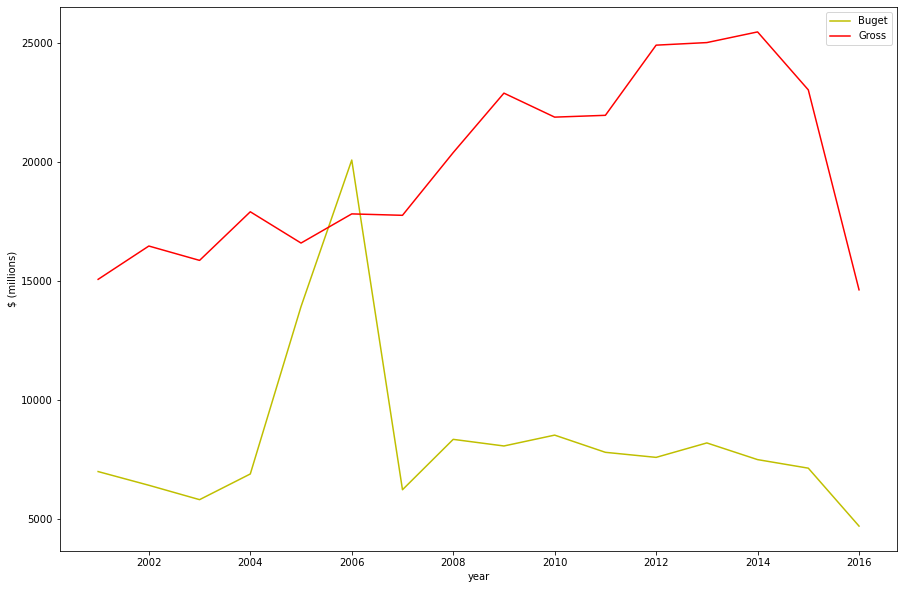

In [435]:
import matplotlib.pyplot as plt
import numpy as np

f = plt.figure(figsize = (15,10))

data_x = year_ratio['year']
data_y1 = year_ratio['Buget (million dollars)']
data_y2 = year_ratio['Gross (million dollars)']

plt.ylabel('$ (millions)')
plt.xlabel('year')

plt.plot(data_x, data_y1, 'y', label='Buget')
plt.plot(data_x, data_y2, 'r', label='Gross')
plt.legend()
plt.show()

In [237]:
# 2.1 Finding the TOP movies by ROI
movies_data['ROI'] = (movies_data['gross_worldwide'] - movies_data['boxoffice_budget']) / movies_data['boxoffice_budget']
movies_data[['imdbID','movie_name','year','director','imdb_rating','boxoffice_budget','gross_worldwide','ROI']].sort_values(by='ROI', ascending=False).head(5).round(decimals=2)

,imdbID,movie_name,year,director,imdb_rating,boxoffice_budget,gross_worldwide,ROI
4793,tt1179904,Actividade Paranormal (2007),2007,Oren Peli,6.3,15000.0,193355800.0,12889.39
4707,tt0185937,O Projecto Blair Witch (1999),1999,Daniel Myrick,6.5,60000.0,248639099.0,4142.98
4799,tt0390538,Tarnation (2003),2003,Jonathan Caouette,7.1,220.0,638521.0,2901.37
4956,tt2309260,The Gallows - Maldição do Passado (2015),2015,Travis Cluff,4.3,100000.0,42964410.0,428.64
4977,tt0390521,Super Size Me - 30 Dias de Fast Food (2004),2004,Morgan Spurlock,7.2,65000.0,20645757.0,316.63


In [10]:
# 2.2 Finding, by genre, the total budget, gross and ROI

genres_roi = genres_melt_t.groupby(['genres'], as_index=False).sum()
genres_roi = genres_roi[genres_roi['genres'] != '']
genres_roi = genres_roi.drop(['oscars','awards_won','awards_nominated'], axis=1)

# Puting in Millions of Dollars
genres_roi['boxoffice_budget'] = genres_roi['boxoffice_budget']/1000000
genres_roi['gross_worldwide'] = genres_roi['gross_worldwide']/1000000
genres_roi = genres_roi[genres_roi['gross_worldwide'] > 0]
genres_roi = genres_roi.rename(columns={"boxoffice_budget": "Buget (million dollars)", "gross_worldwide": "Gross (million dollars)"})

genres_roi['ROI'] = (genres_roi['Gross (million dollars)'] - genres_roi['Buget (million dollars)']) / genres_roi['Buget (million dollars)']
genres_roi = genres_roi[genres_roi['ROI'] < 30]
genres_roi = genres_roi.sort_values(by='ROI', ascending=False).round(decimals=2)
genres_roi

NameError: name 'genres_melt_t' is not defined

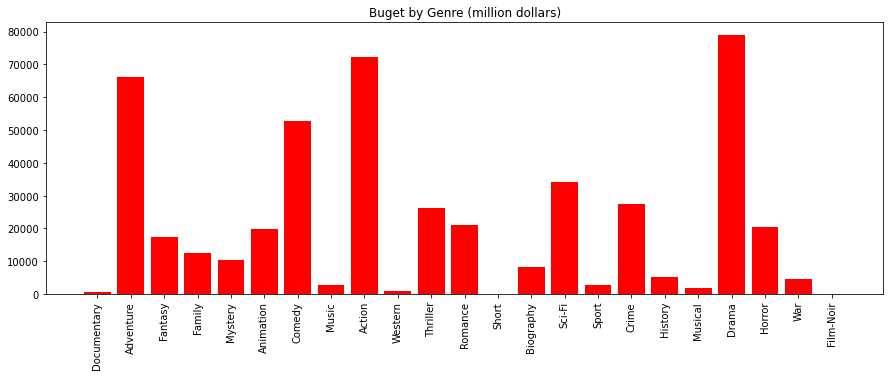

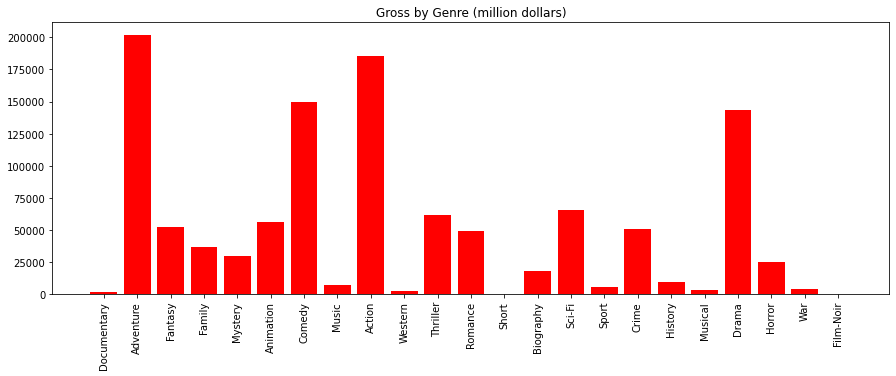

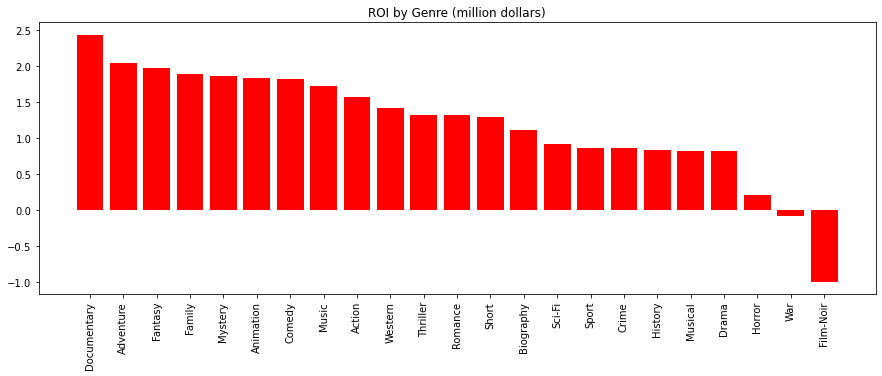

In [443]:
f = plt.figure(figsize = (15,5))
plt.bar(genres_roi['genres'], genres_roi['Buget (million dollars)'], facecolor = 'r')
plt.xticks(rotation=90)
plt.title('Buget by Genre (million dollars)')
plt.show()

f = plt.figure(figsize = (15,5))
plt.bar(genres_roi['genres'], genres_roi['Gross (million dollars)'], facecolor = 'r')
plt.xticks(rotation=90)
plt.title('Gross by Genre (million dollars)')
plt.show()

f = plt.figure(figsize = (15,5))
plt.bar(genres_roi['genres'], genres_roi['ROI'], facecolor = 'r')
plt.xticks(rotation=90)
plt.title('ROI by Genre (million dollars)')
plt.show()

In [453]:
# 2.3 Finding the TOP directors by ROI
best_director = movies_data.groupby(['director'], as_index=False).agg({'imdbID':'count', 'boxoffice_budget':'sum', 'gross_worldwide':'sum'})
best_director = pd.DataFrame(best_director)

# Puting in Millions of Dollars
best_director['boxoffice_budget'] = best_director['boxoffice_budget']/1000000
best_director['gross_worldwide'] = best_director['gross_worldwide']/1000000


best_director = best_director.rename(columns={"boxoffice_budget": "Buget (million dollars)", "gross_worldwide": "Gross (million dollars)"})

best_director['ROI'] = (best_director['Gross (million dollars)'] - best_director['Buget (million dollars)']) / best_director['Buget (million dollars)']
best_director.sort_values(by='imdbID', ascending=False).head(5).round(decimals=2)

,director,imdbID,Buget (million dollars),Gross (million dollars),ROI
2244,Steven Spielberg,26,1662.5,9640.12,4.80
2469,Woody Allen,22,341.8,833.65,1.44
1537,Martin Scorsese,20,913.6,2117.33,1.32
409,Clint Eastwood,20,764.6,2501.52,2.27
1973,Ridley Scott,16,1290.0,3319.43,1.57


In [422]:
# RATINGS

genres_ratings = pd.merge(genres_melt_t, movies_ratings_imdb, how='inner', left_on='imdbID', right_on='Movie Id')
genres_ratings = genres_ratings.sort_values(by='imdbID', ascending=False)
genres_ratings = genres_ratings[genres_ratings['genres'] != '']
genres_ratings = genres_ratings[['imdbID','genres','Gender','All Ages','<18','18-29','30-44','45+']]
genres_ratings.head(6)

,imdbID,genres,Gender,All Ages,<18,18-29,30-44,45+
29616,tt5574490,Drama,All,8.2,9.6,8.3,8.1,8.2
29615,tt5574490,Crime,Females,8.4,9.3,8.3,8.4,8.4
29614,tt5574490,Crime,Males,8.0,7.0,8.2,8.0,8.0
29613,tt5574490,Crime,All,8.2,9.6,8.3,8.1,8.2
29618,tt5574490,Drama,Females,8.4,9.3,8.3,8.4,8.4
29617,tt5574490,Drama,Males,8.0,7.0,8.2,8.0,8.0


In [15]:
genres_ratings = pd.read_excel('generos_imdb.xlsx')
genres_ratings

,genres,All Ages,<18,18-29,30-44,45+
0,Action,6.27,6.39,6.41,6.22,6.27
1,Adventure,6.40,6.45,6.48,6.35,6.40
2,Animation,6.57,6.69,6.62,6.53,6.57
3,Biography,7.13,7.14,7.24,7.08,7.13
4,Comedy,6.21,6.27,6.32,6.16,6.21
5,Crime,6.53,6.70,6.69,6.51,6.53
6,Documentary,7.11,7.15,7.12,7.05,7.11
7,Drama,6.74,6.85,6.86,6.70,6.74
8,Family,6.20,6.15,6.28,6.12,6.20
9,Fantasy,6.18,6.34,6.24,6.12,6.18


In [454]:
genres_ratings = genres_ratings[genres_ratings['genres'] != '']
genres_ratings = genres_ratings.groupby(['genres'], as_index=False).mean().round(decimals=2)
genres_ratings

,genres,All Ages,<18,18-29,30-44,45+
0,Action,6.27,6.39,6.41,6.22,6.27
1,Adventure,6.40,6.45,6.48,6.35,6.40
2,Animation,6.57,6.69,6.62,6.53,6.57
3,Biography,7.13,7.14,7.24,7.08,7.13
4,Comedy,6.21,6.27,6.32,6.16,6.21
5,Crime,6.53,6.70,6.69,6.51,6.53
6,Documentary,7.11,7.15,7.12,7.05,7.11
7,Drama,6.74,6.85,6.86,6.70,6.74
8,Family,6.20,6.15,6.28,6.12,6.20
9,Fantasy,6.18,6.34,6.24,6.12,6.18


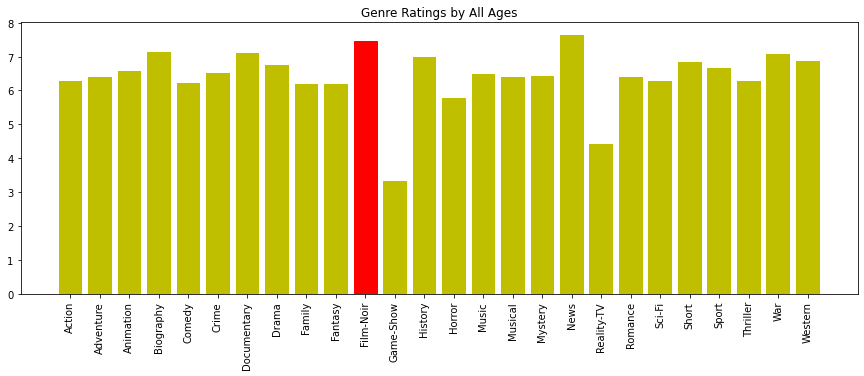

In [23]:
f = plt.figure(figsize = (15,5))
barlist1= plt.bar(genres_ratings['genres'], genres_ratings['All Ages'], facecolor = 'y')
plt.xticks(rotation=90)
plt.title('Genre Ratings by All Ages')
barlist1[10].set_color('r')
plt.show()

# f = plt.figure(figsize = (15,5))
# barlist2= plt.bar(genres_ratings['genres'], genres_ratings['<18'], facecolor = 'y')
# plt.xticks(rotation=90)
# plt.title('Genre Ratings by <18')
# barlist2[21].set_color('r')
# plt.show()

# f = plt.figure(figsize = (15,5))
# barlist3= plt.bar(genres_ratings['genres'], genres_ratings['18-29'], facecolor = 'y')
# plt.xticks(rotation=90)
# plt.title('Genre Ratings by 18-29')
# barlist3[10].set_color('r')
# plt.show()

# f = plt.figure(figsize = (15,5))
# barlist4= plt.bar(genres_ratings['genres'], genres_ratings['30-44'], facecolor = 'y')
# plt.xticks(rotation=90)
# plt.title('Genre Ratings by 30-44')
# barlist4[17].set_color('r')
# plt.show()

# f = plt.figure(figsize = (15,5))
# barlist5= plt.bar(genres_ratings['genres'], genres_ratings['45+'], facecolor = 'y')
# plt.xticks(rotation=90)
# plt.title('Genre Ratings by 45+')
# barlist5[17].set_color('r')
# plt.show()

In [427]:
# 4.1 Finding, by genre, the total amount of awards wonn

genres_awards = genres_melt_t.groupby(['genres'], as_index=False).sum()
genres_awards = genres_awards.drop(['boxoffice_budget','gross_worldwide'], axis=1)

genres_awards = genres_awards[genres_awards['genres'] != '']
genres_awards = genres_awards[genres_awards['awards_nominated'] >= genres_awards['awards_won']]

genres_awards['Awards Rate'] = genres_awards['awards_won']/genres_awards['awards_nominated']
genres_awards = genres_awards.sort_values(by='Awards Rate', ascending=False).round(decimals=2)
genres_awards.head()

,genres,oscars,awards_won,awards_nominated,Awards Rate
7,Documentary,21,592,637,0.93
12,Game-Show,0,9,11,0.82
19,Reality-TV,0,9,11,0.82
25,War,117,1266,1598,0.79
15,Music,75,1219,2210,0.55


###### f = plt.figure(figsize = (15,5))

plt.bar(genres_awards['genres'], genres_awards['Awards Rate'], facecolor = 'r')
plt.xticks(rotation=90)
plt.title('Awards Success Rate by Genre')
plt.show()

In [36]:
# 4.2 Find movie with best success rate of awards won
movies_awards = movies_data[['imdbID','movie_name','oscars','awards_won','awards_nominated']]
movies_awards = movies_awards[movies_awards['awards_nominated'] >= movies_awards['awards_won']]
movies_awards = movies_awards[movies_awards['awards_nominated'] > 1]
movies_awards = movies_awards[movies_awards['oscars'] > 1]
movies_awards['success_rate'] = movies_awards['awards_won'] / movies_awards['awards_nominated']
movies_awards = movies_awards[movies_awards['success_rate'] == 1]

movies_awards = movies_awards.sort_values(by='awards_won', ascending=False).head().round(decimals=2)
movies_awards

,imdbID,movie_name,oscars,awards_won,awards_nominated,success_rate
2673,tt0094947,Ligações Perigosas (1988),3,21,21,1.0
1522,tt0111257,Speed - Perigo a Alta Velocidade (1994),2,20,20,1.0
4410,tt0057590,"Tom Jones, Romântico e Aventureiro (1963)",4,20,20,1.0
4064,tt0057163,Hud: O Mais Selvagem Entre Mil (1963),3,17,17,1.0
3927,tt0038650,Do Céu Caiu Uma Estrela (1946),5,6,6,1.0


In [30]:
# 4.2 Find movie with most awards won
movies_awards = movies_data[['imdbID','movie_name','oscars','awards_won','awards_nominated']]
movies_awards['success_rate'] = movies_awards['awards_won'] / movies_awards['awards_nominated']
movies_awards = movies_awards.sort_values(by='awards_won', ascending=False).head().round(decimals=2)
movies_awards

<ipython-input-30-b36e8605e5ed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_awards['success_rate'] = movies_awards['awards_won'] / movies_awards['awards_nominated']


,imdbID,movie_name,oscars,awards_won,awards_nominated,success_rate
115,tt1392190,Mad Max: A Estrada da Morte (2015),6,245,231,1.06
2087,tt2024544,12 Anos Escravo (2013),3,242,336,0.72
224,tt1454468,Gravidade (2013),7,238,187,1.27
306,tt0167260,O Senhor dos Anéis - O Regresso do Rei (2003),11,209,124,1.69
2324,tt2562232,Birdman ou (A Inesperada Virtude da Ignorância...,4,193,291,0.66


In [31]:
# 4.2 Find movie with most nominations
movies_awards = movies_data[['imdbID','movie_name','oscars','awards_won','awards_nominated']]
movies_awards['success_rate'] = movies_awards['awards_won'] / movies_awards['awards_nominated']
movies_awards = movies_awards.sort_values(by='awards_nominated', ascending=False).head().round(decimals=2)
movies_awards

<ipython-input-31-8d52f89896b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_awards['success_rate'] = movies_awards['awards_won'] / movies_awards['awards_nominated']


,imdbID,movie_name,oscars,awards_won,awards_nominated,success_rate
3187,tt0092325,The Bold and the Beautiful (TV Series 1987– ),0,125,382,0.33
2087,tt2024544,12 Anos Escravo (2013),3,242,336,0.72
2324,tt2562232,Birdman ou (A Inesperada Virtude da Ignorância...,4,193,291,0.66
2730,tt0947798,Cisne Negro (2010),1,97,279,0.35
613,tt0443272,Lincoln (2012),2,107,252,0.42
